# SJ Price Algorithm

This notebook creates a price algorithm for Saint James hostel that takes into account demand over an N day period and includes the following adjustable parameters: 1) base rate, 2) elasticity, 3) number of additional days, 4) time penalty (the declining importance of each additional day ahead's demand on the overall average), 5) weekend multiplier, and 6) floor ratio. 

## Algorithm

[1]
$$
EA_{𝑖} = (1-(\frac{S_{𝑖}}{C}))*E
$$

<br/>

Where... 
* EA = elasticity ajusted rate
* S = space (number of beds left)
* C = capacity (total number of beds)
* E = elasticity (the rate at which the price fluctuates - with 1 as the average)

<br/>
<br/>

[2]
$$
DA_{𝑖} = \frac{EA_{𝑖} + (EA_{𝑖+1}*T_{1}) + ... + (EA_{𝑖+N}*T_{N})}{1+ T_{1} + ... + T_{N}}
$$

<br/>

Where... 
* DA = days ajusted rate
* N = number of future days to take into account
* T = time penalty (how much less important each additional day is than the one before - as a proportion)


<br/>
<br/>

[3]

$$
WA_{𝑖} = \begin{cases} DA_{𝑖}*W, & \text{ if } D_{𝑖}=(Friday|Saturday)\\ DA_{𝑖}, & \text{ otherwise }\end{cases}
$$

<br/>
<br/>

Where... 
* WA = weekend ajusted rate
* { = conditional value assignment
* D = day of the week
* W = weekend multiplier (e.g. 1.5 if 50% more than weekday rates)

<br/>
<br/>

[4]
$$
P_{𝑖} = \begin{cases} WA_{𝑖}*B, & \text{ if } WA_{𝑖} > F\\F*B, & \text{ otherwise } \end{cases}
$$

Where... 
* P = final price
* B = base price
* F = floor ratio (a fraction of the base price - e.g. 0.75 would be 75% of the base price)


<br/>

## Adjustable parameters

    * E = elasticity
    * N = number of additonal days
    * T = time penalty
    * W = weekend multiplier
    * F = floor ratio
    * B = base rate

## Simulations

A series of simulations are run on example data for the 8 bedroom mixed dorm to see how adjusting the parameters wouuld affect the price.

### Import libraries

In [1]:
# imports key libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Calculation functions

In [2]:
# calculates the days adjusted rate based on a variable N
def calc_DA(EA, i, S, D, C, B, E, N, T, W, F):
    
    if type(N) != int:
        N = int(N)
    
    add = []
    divide = []
    for j in range(N-1):
        add.append((((1-(S[i+j]/C))*E) * T**j))
        divide.append(T**j)
    return ( EA + sum(add) ) / ( 1 + sum(divide) )

# calculates a set of prices based on space and day of the week
def calc_prices(S, D, C, B, E, N, T, W, F):
    # loops through each day to get a price
    prices = []
    for i in range(len(D)):
        
        # elasticity adjusted rate
        EA = (1-(S[i] / C )) * E
        
        # days adjusted rate
        DA = calc_DA(EA, i, S, D, C, B, E, N, T, W, F)
        
        # weekend adjusted rate
        if D[i] in ['Friday', 'Saturday']:
            WA = DA * W
        else:
            WA = DA
            
        # floor adjusted rate
        if WA < F:
            FA = F
        else:
            FA = WA
            
        # final price
        prices.append( round(FA*B, 1) )
        
    return prices

### Visualization functions

In [3]:
# returns a simple line plot
def line_plot(prices, title='', color='tab:blue'):
    s_strings = [str(x) for x in S[0:14]]
    plt.plot(s_strings, prices, color=color);
    plt.title(title, fontsize=18);
    plt.xlabel('Space', fontsize=14);
    plt.ylabel('Price', fontsize=14);
    plt.xticks(fontsize=8);
    plt.yticks(fontsize=8);
    plt.show();
    
# returns a subplot of line graphs to see how changing paramter values affects the price
def params_plot(var, title, color, decimal=1):
    # determines the parameter to vary based on first letter of the title
    params = ['S', 'D', 'C', 'B', 'E', 'N', 'T', 'W', 'F']
    chosen_param = [i for i, x in enumerate(params) if x == title[0]]
    params[chosen_param[0]] = params[chosen_param[0]] + '[num]'
    
    # defines some variables for the subplots
    length = len(var)
    cols = 3
    rows = int(np.ceil(length / 3))
    
    # creates an object for the space variable
    s_strings = [str(x) for x in S[0:14]]
    
    # creates a subplots object
    fig, ax = plt.subplots(rows, cols, figsize=(15,9))
    fig.tight_layout(pad=5);
    fig.suptitle(title, y=1.025, fontsize=25);
    
    # loops through each variation in the parameter values 
    for i in range(rows):
        for j in range(cols):
            num = (i*rows)+j
            prices = calc_prices(S=eval(params[0]), D=eval(params[1]), C=eval(params[2]), B=eval(params[3]), E=eval(params[4]), N=eval(params[5]), T=eval(params[6]), W=eval(params[7]), F=eval(params[8]))
            ax[i, j].plot(s_strings, prices, color=color);
            ax[i, j].set_title(title[0] + ' = ' + str(round(var[num], decimal)), fontsize=18);
            ax[i,j].set_xlabel('Space left', fontsize=14);
            ax[i,j].set_ylabel('Price', fontsize=14);
            ax[i,j].tick_params(axis='both', which='minor', labelsize=8)

### Initial parameters

We can see from the initial parameter settings that the price declines rapidly after more than 2 beds become available - with only the weekend multiplier raising prices slightly after hitting the floor price at 6 beds. This shows us that we should alter the parameters to achieve greater variability in our pricing.

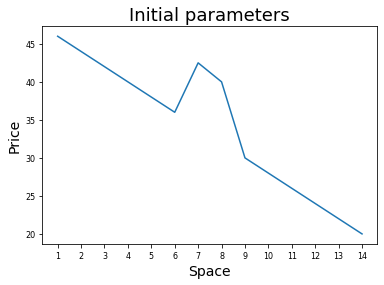

In [4]:
# space (beds left over a 2 week period)
S = range(1,29)

# day (whether a weekend or not)
D = ['Sunday', 'Monday', 'Tuesday'] * 2 + ['Friday', 'Saturday'] +  ['Sunday', 'Monday', 'Tuesday'] * 2

# capacity (total beds available)
C = 24

# base price (can be thought of as an average)
B = 40

# elasticity (with 1 as the average)
E = 1.2

# number of days in the future to include
N = 0

# importance of each additonal day compared to the previous
T = 0.75

# weekend multiplier
W = 1.25

# floor rate (the lowest possible multilier of the base price)
F = 0.5

# calculate prices based on initial params
prices = calc_prices(S, D, C, B, E, N, T, W, F)

# visualize the results
line_plot(prices, title='Initial parameters')

### Elasticity

Experimenting with different elasticity (E) values between 1 and 2 shows us that an E of 1.25 would give us sufficient price variability without allowing fluctuations to become so large that potential customers would never consider paying. 

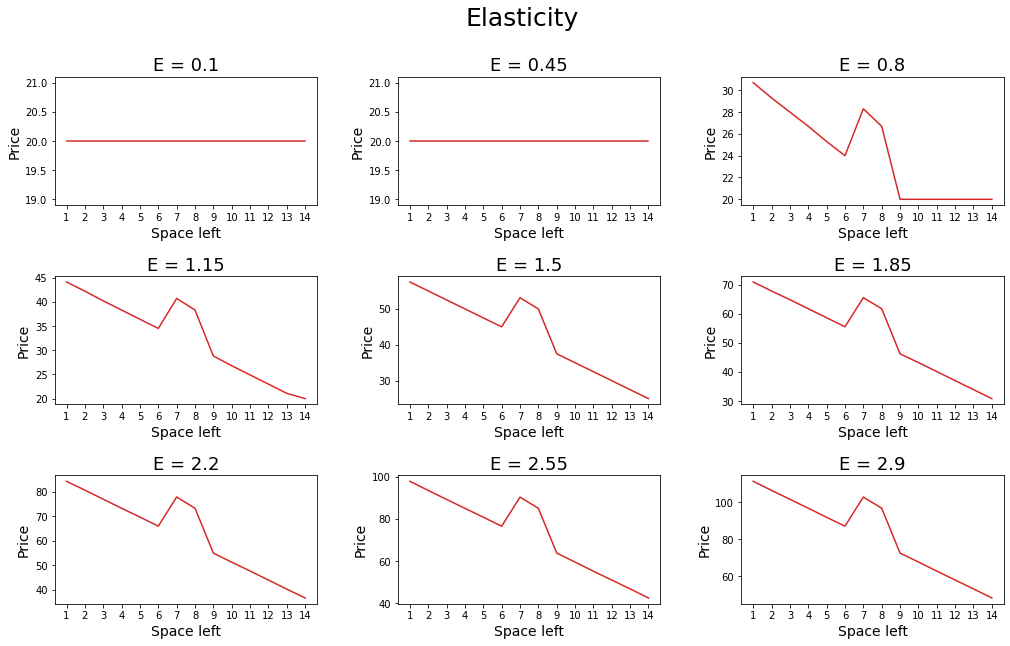

In [5]:
# creates a sequence of different E values to try
E = np.linspace(0.1, 2.9, 9)

# visualizes the sequence of E values
params_plot(E, 'Elasticity', 'tab:red', 3)

### Number of additional days

Examining different number of additional days (N) values between 0 and 16 indicates that an N of around 5 is enough to make the price responsive to the immediate future without leading to excessively rapid price drops when confronted with a coming period of lower demand and vice versa.

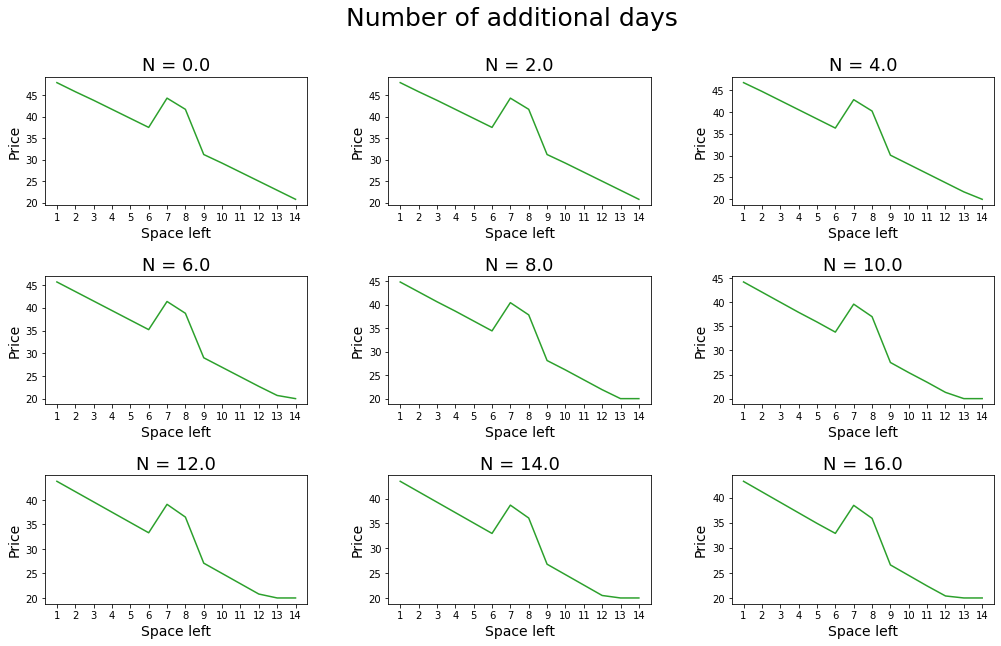

In [6]:
# assigns E the preffered value of 1.25
E = 1.25

# creates a sequence of different E values to try
N = np.linspace(0, 16, 9)

# visualizes the sequence of E values
params_plot(N, 'Number of additional days', 'tab:green')

### Time penalty

As for number of additional days, investigating the effects of different time penalty values (T) illustrates that a T of 0.8 is enough to make the price responsive to the immediate future without leading to excessively rapid price drops when confronted with a coming period of lower demand and vice versa.

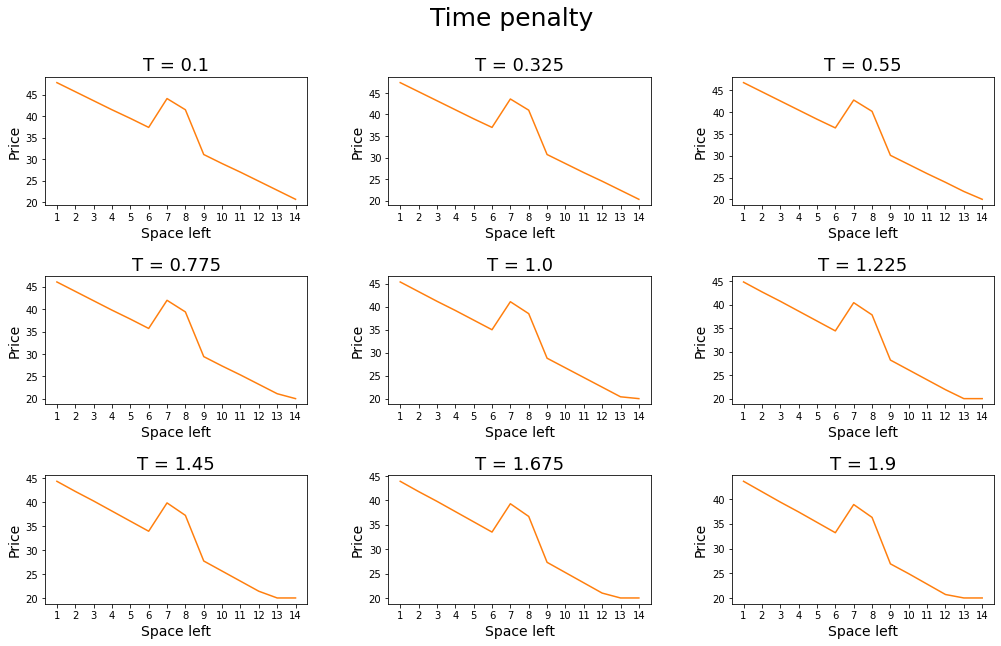

In [7]:
# assigns N the preffered value of 5
N = 5

# creates a sequence of different E values to try
T = np.linspace(0.1, 1.9, 9)

# visualizes the sequence of E values
params_plot(T, 'Time penalty', 'tab:orange', 3)

### Weekend multiplier

Trying out different weekend multiplier (W) values between 1 and 2 demonstrates that a W of 1.5 would likely raise prices enough to compensate for the anticipated extra demand but not so much as to discourage potential customers.

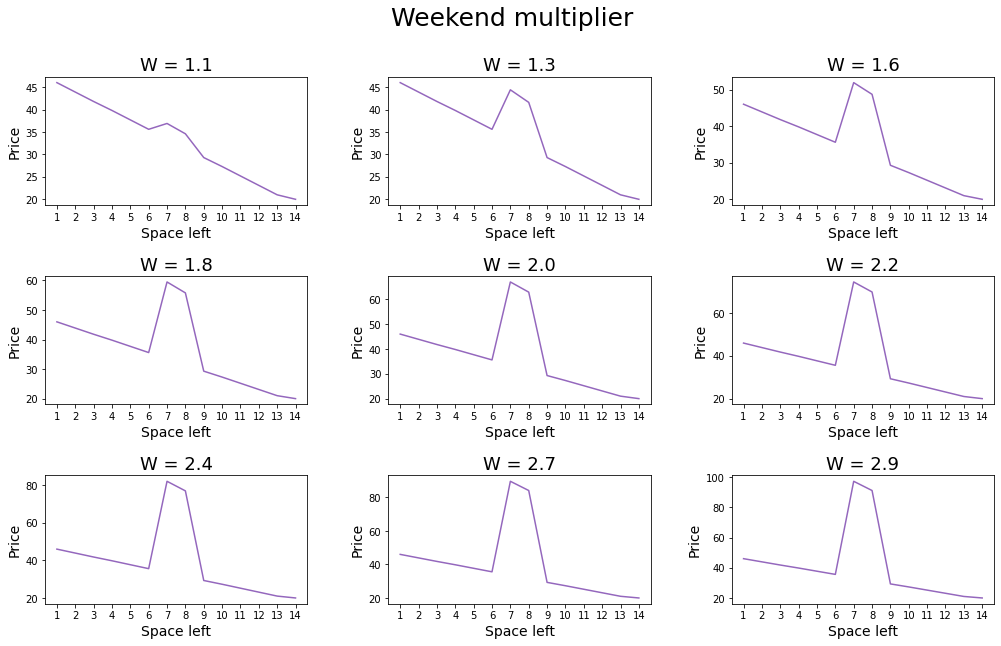

In [8]:
# assigns I the preffered value of 0.8
T = 0.8

# creates a sequence of different W values to try
W = np.linspace(1.1, 2.9, 9)

# visualizes the sequence of W values
params_plot(W, 'Weekend multiplier', 'tab:purple')

### Floor ratio

Testing the impact of different floor ratio (F) values between 0 and 2 tells us that an F of 0.6 would allow us to hit our price floor at around 12 beds (50% capacity), allowing us to reduce the price somewhat to encourage additional demand but without going too low. 

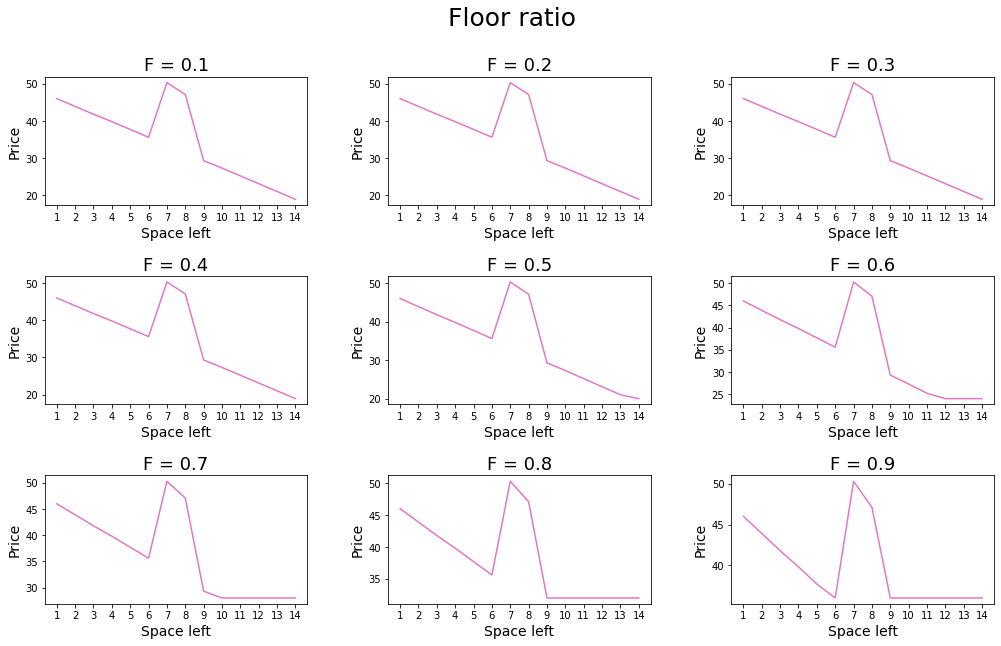

In [9]:
# assigns W the preffered value of 1.5
W = 1.5

# creates a sequence of different F values to try
F = np.linspace(0.1, 0.9, 9)

# visualizes the sequence of FR values
params_plot(F, 'Floor ratio', 'tab:pink')

### Base price

Trialing different base price (B) values between 10 and 90 tells us that a B of 40 would allow us to charge extra during expeptionally busy times without 1) reaching excessively high amounts and 2) allowing the price to drop too low.

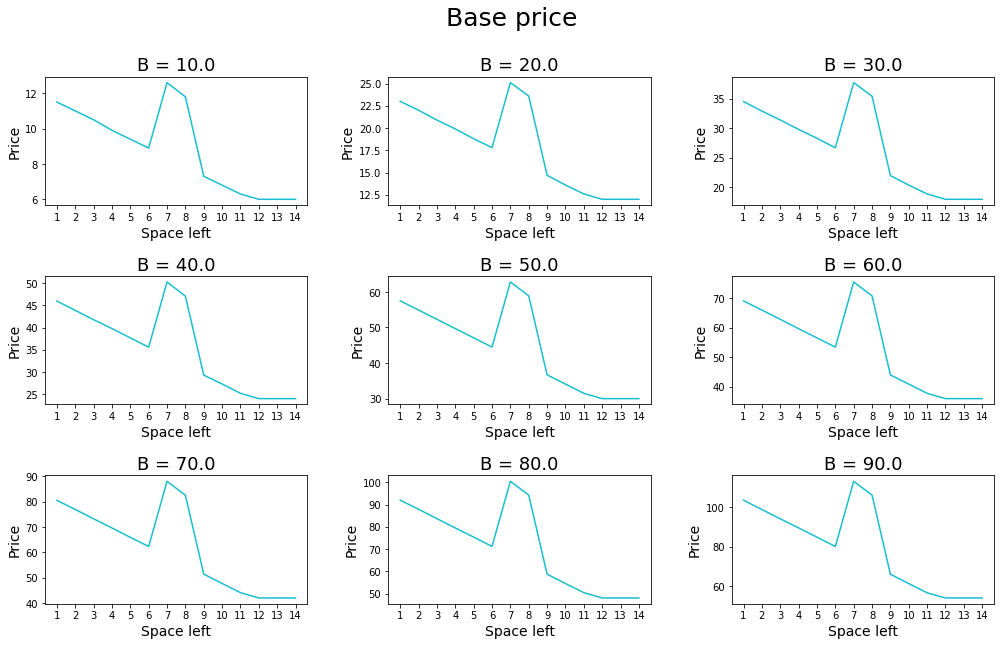

In [10]:
# assigns F the preffered value of 0.6
F = 0.6

# creates a sequence of different FR values to try
B = np.linspace(10, 90, 9)

# visualizes the sequence of FR values
params_plot(B, 'Base price', 'tab:cyan')